# Customer Personality Analysis - Unsupervised Learning


# Project Topic and Goal

In this project, the task at hand is to build an unsupervised machine learning model for customer segmentation. The primary objective is to compare various clustering algorithms, including K-Means, and potentially use PCA for dimensionality reduction on the customer data. The purpose of customer segmentation, from a business standpoint, is to gain insights into customer preferences and behavior. By analyzing factors such as income and spending on products, the goal is to identify distinct customer segments. This information will empower the company to implement targeted marketing strategies tailored to each segment's needs and preferences, ultimately leading to increased revenue and improved marketing efficiency.

# Data


The dataset itself has a CSV format with a size of around 220kB which is really small. This means we don't have to worry processing large amounts of data. The format is tabular with 29 columns and 2240 rows in total.

A first glance at the data shows that we have to work with features both numerical and categorical. The features itself can be grouped into different categories:

* People (Year of birth, education level, ...)
* Products (Amount spent on fruits in last 2 years, ...)
* Promotion (Number of purchases made with discount, ...)
* Place (Number of purchases made through website, ...)

# Import Python Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.metrics import davies_bouldin_score

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Exploratory Data Analysis

We will start with exploring our data set several built-in dataframe methods and visualizations.

## 1 Data Description

In [28]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [29]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [30]:
df.shape

(2240, 29)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

We are working with a dataset of 2240 rows and 29 columns. We inspect that there are some missing values in the "Income" column. We will take care of these in the next part.

## 2 Data Cleaning and Preprocessing (10 marks)

### 2.1 Missing Values

First, we check for NA or NULL values using the built-in functions of pandas dataframes (to confirm our inspection of missing values from before).

In [32]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

The observation shows that there are indeed 24 NA respectively NULL values in the 'Income' column but no empty strings or spaces in any other column. Since income might be an important indicator wether a customer belongs to this or another cluster we should definitely take care of them. There are several commonly used strategies:

* Impute missing values based on their underlying distribution
* Drop rows with empty values
* Use advanced imputation techniques like regression imputation

We will start by looking at the distribution of the valid values.

In [9]:
def plot_income_dist(df):
    plt.hist(df['Income'], bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Income')
    plt.show()

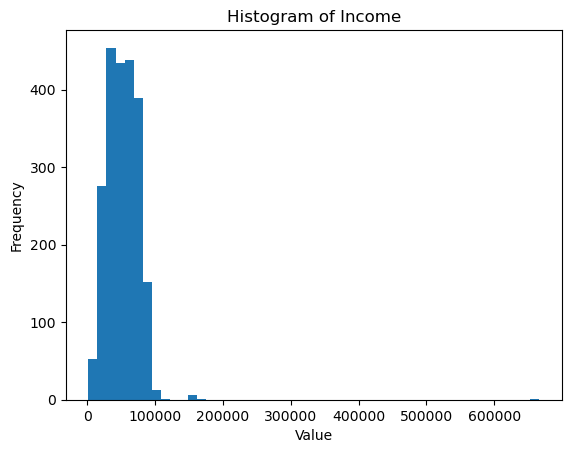

In [10]:
plot_income_dist(df)

From the histogram we can assume that most of the income data follows a normal distribution. But we have a few outliers to to the right side at an income of approximately 150000 and even one extreme outlier at an income of over 600000. Let's define a treshold at 200000 and see how many samples fall below and above it.  

In [34]:
# Write your code here
df_above = df[df.Income>200000].shape[0]/df.shape[0]*100
df_below = df[df.Income<=200000].shape[0]/df.shape[0]*100
print('%Customer with Income>200000 : ',df_above,'%')
print('%Customer with Income<=200000 : ',df_below,'%')

%Customer with Income>200000 :  0.044642857142857144 %
%Customer with Income<=200000 :  98.88392857142857 %


Since only around 0.05% of our customers have an income of over 200000 we can safely ignore these by dropping the respective samples. Since there are still a few customers with income of around 150000 we cannot assume normality for the distribution due to the skewness to the right side. But we do not want to drop them since they could be part of an high income cluster or even form its own cluster. As a consequence, we cannot simply impute the missing values by using the mean but rather use the median value. 

In [42]:
# drop customers with income greater than 200000
df2 = df.copy()
df2 = df2[(df2.Income<=200000) | df.Income.isna()]
df2.shape

(2239, 29)

In [45]:
# impute median income for missing values
median_income = df2.Income.median()
df2.Income.fillna(median_income, inplace=True)
df2.isna().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

The output shows that there are no missing values anymore. Again, we can have a look at the histogram to see the underlying distribution in greater resolution containing the imputed values.

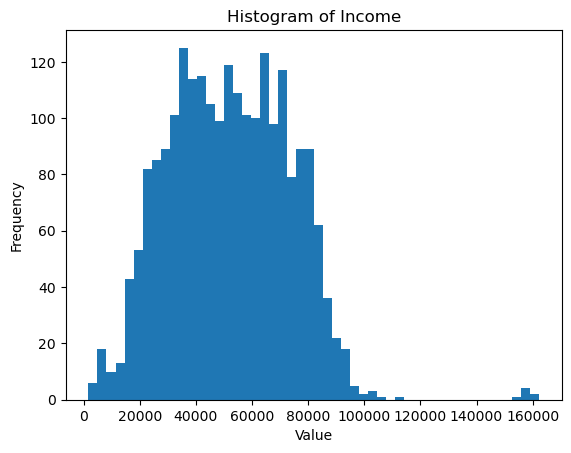

In [46]:
plot_income_dist(df2)

In [47]:
df2.sample(5)

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
358   6142        1943      Master        Married  65073.0        0         0   
1911  5544        1970  Graduation         Single  67384.0        0         1   
1570  4261        1946         PhD         Single  82800.0        0         0   
2196  1839        1974  Graduation         Single  43322.0        0         0   
575   2574        1977         PhD        Married  61996.0        0         1   

     Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
358   20-08-2013       65       629  ...                  2             0   
1911  10-11-2012       32       957  ...                  5             0   
1570  24-11-2012       23      1006  ...                  3             0   
2196  21-04-2014       25        56  ...                  7             0   
575   31-01-2013       27      1050  ...                  5             0   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
358              0             0             0             0         1   
1911             1             0             0             0         0   
1570             0             1             1             0         0   
2196             0             0             0             0         0   
575              1             0             1             1         0   

      Z_CostContact  Z_Revenue  Response  
358               3         11         0  
1911              3         11         0  
1570              3         11         1  
2196              3         11         0  
575               3         11         1  

[5 rows x 29 columns]

### 2.2 Inspecting numerical features


The first thing to notice here is that both the 'Z_CostContact' and 'Z_Revenue' column have the same value over all samples. Unfortunetaly, the dataset provides no explanation what these two columns are about. But since there is always the same value there is no impact on our model building and we can simply drop them.

We can also see that the ID column (by nature) has no significant meaning for our clustering approach. We will drop this one as well.

Many features seem to follow some sort of exponential distribution. For example, looking at the 'MntFishProducts' column that means that most of our customers have spent a pretty small amount of money on fish in last 2 years. This makes sense since fish often times can be quite expensive and less people have enough buying power to purchase large amounts of it.

There are also some features with outliers. For example, the 'NumDealsPurchases' column which represent the number of purchases made with a discount has quite a few samples with higher numbers. But again, this could be of significant meaning to our clutering goal and potentially form its own cluster. Therefore we won't drop those samples.

In [48]:
# drop irrelevant columns
columns_to_drop = ['ID', 'Z_CostContact', 'Z_Revenue']
# write your code here
df2.drop(columns=columns_to_drop,  axis=1, inplace=True)
df2.shape

(2239, 26)

In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2239 non-null   int64  
 1   Education            2239 non-null   object 
 2   Marital_Status       2239 non-null   object 
 3   Income               2239 non-null   float64
 4   Kidhome              2239 non-null   int64  
 5   Teenhome             2239 non-null   int64  
 6   Dt_Customer          2239 non-null   object 
 7   Recency              2239 non-null   int64  
 8   MntWines             2239 non-null   int64  
 9   MntFruits            2239 non-null   int64  
 10  MntMeatProducts      2239 non-null   int64  
 11  MntFishProducts      2239 non-null   int64  
 12  MntSweetProducts     2239 non-null   int64  
 13  MntGoldProds         2239 non-null   int64  
 14  NumDealsPurchases    2239 non-null   int64  
 15  NumWebPurchases      2239 non-null   i

We should also take care of the "Dt_Customer" column which represent the date of the customer's enrollment with the company. This representation will likely cause problems when applying techniques as PCA and model building due to its datatype. Therefore, we will convert this column into a new column that represents the number of days the customer is enrolled with the company which we can represent using an integer.

In [62]:
# convert to datetime format
df2.Dt_Customer = pd.to_datetime(df2.Dt_Customer)

# get number of days since enrollment
df2['number_of_days'] = df2.Dt_Customer.max()-df2.Dt_Customer

# drop original column since it is not needed anymore
df2.drop('Dt_Customer', axis=1, inplace=True)

df2.number_of_days

0      971 days
1      125 days
2      472 days
3       65 days
4      321 days
         ...   
2235   541 days
2236    61 days
2237   315 days
2238   316 days
2239   782 days
Name: number_of_days, Length: 2239, dtype: timedelta64[ns]

In [90]:
df2.number_of_days = df2.number_of_days.dt.days.astype('int')
df2.number_of_days

0       971
1       125
2       472
3        65
4       321
       ... 
2235    541
2236     61
2237    315
2238    316
2239    782
Name: number_of_days, Length: 2235, dtype: int32

The fact that we use the current date as a reference should not impact model performance since we will standardize our data before applying PCA and model building. The main focus here is to catch the relative durations for each customer to compare them with each other.

Since clustering methods can suffer from high dimensionality we should aim for reducing dimensions as much as possible. For this purpose we will combine all columns related to spending a certain amount on a specific product and create a new column that shows the total amount spent.

In [63]:
# combine columns and drop original ones
df2['TotalSpent'] = df2['MntWines'] + df2['MntFruits'] + df2['MntMeatProducts'] + df2['MntFishProducts'] + df2['MntSweetProducts'] + df2['MntGoldProds']
columns_to_drop = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df2.drop(columns=columns_to_drop, inplace=True)

In [64]:
df2.head()

Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  Recency  \
0        1957  Graduation         Single  58138.0        0         0       58   
1        1954  Graduation         Single  46344.0        1         1       38   
2        1965  Graduation       Together  71613.0        0         0       26   
3        1984  Graduation       Together  26646.0        1         0       26   
4        1981         PhD        Married  58293.0        1         0       94   

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  ...  \
0                  3                8                   10  ...   
1                  2                1                    1  ...   
2                  1                8                    2  ...   
3                  2                2                    0  ...   
4                  5                5                    3  ...   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   
3                  6             0             0             0             0   
4                  5             0             0             0             0   

   AcceptedCmp2  Complain  Response  number_of_days TotalSpent  
0             0         0         1        971 days       1617  
1             0         0         0        125 days         27  
2             0         0         0        472 days        776  
3             0         0         0         65 days         53  
4             0         0         0        321 days        422  

[5 rows x 21 columns]

### 2.3 Inspecting categorical features


Except for 'Education' and 'Marital_Status' all categorical features take on only 2 possible values 0 and 1.

Most of our customers are married or at least living together. For the 'Marital_Status' feature we have many different possible values. There are also some categories like 'YOLO' or 'Absurd' that don't make sense and are not explained any futher in the dataset description. We will drop these two since they only represent a very small part of the samples. To reduce model complexity futher we will combine 'Married' and 'Together' to create a new category 'Relationship' and we will also combine 'Single', 'Divorced', 'Widow', and 'Alone' to a new category 'No Relationship'.

For 'Education' it is quite hard to say what 'Graduation', '2n Cycle', and 'Basic' means. Since those categories are not negligible due to the corresponding amount of customers we will leave them as they are. 

In [66]:
df2.Education.value_counts()

Graduation    1126
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [65]:
df2.Marital_Status.value_counts()

Married     864
Together    579
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [70]:
# remove samples with 'Absurd' and 'YOLO' marital status
df2 = df2[~df2.Marital_Status.isin(['Absurd', 'YOLO'])]

# combine categories of marital status
conditions = {
    'Married': 'Relationship',
    'Together': 'Relationship',
    'Single': 'No Relationship',
    'Divorced': 'No Relationship',
    'Widow': 'No Relationship',
     'Alone': 'No Relationship'
}
df2.Marital_Status = df2.Marital_Status.replace(conditions)

In [71]:
df2.Marital_Status.value_counts()

Relationship       1443
No Relationship     792
Name: Marital_Status, dtype: int64

In order to reduce the number of dimensions further, we could combine the "AcceptedCmp..." and "Response" columns by creating a new column that represents whether a customer is susceptible for marketing campaigns or not.

In [73]:
# create combined column and drop original ones
campaign_columns = ['AcceptedCmp1','AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df2['CampaignAccepted'] = df2[campaign_columns].any(axis=1)
df2 = df2.drop(campaign_columns, axis=1)

In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2235 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Year_Birth           2235 non-null   int64          
 1   Education            2235 non-null   object         
 2   Marital_Status       2235 non-null   object         
 3   Income               2235 non-null   float64        
 4   Kidhome              2235 non-null   int64          
 5   Teenhome             2235 non-null   int64          
 6   Recency              2235 non-null   int64          
 7   NumDealsPurchases    2235 non-null   int64          
 8   NumWebPurchases      2235 non-null   int64          
 9   NumCatalogPurchases  2235 non-null   int64          
 10  NumStorePurchases    2235 non-null   int64          
 11  NumWebVisitsMonth    2235 non-null   int64          
 12  Complain             2235 non-null   int64          
 13  number_of_days    

In [104]:
df2.CampaignAccepted = df2.CampaignAccepted.astype('int')

After all these steps we have reduced our dataset down to only 16 columns.

### 2.4 One-Hot Encoding

Now that we have inspected our categorical variables we need to preprocess them in order to use them in our machine learning models. One popular method is called One-hot encoding and is a technique used in machine learning to convert categorical data into a numerical format. Each category in the original feature is transformed into a new binary feature, where 1 represents the presence of the category and 0 represents the absence. This way we preserve all the information in our dataset by making each category a seperate feature.

In [105]:
# apply one-hot encoding to our categorical columns
df_encoded = pd.get_dummies(df2)
df_encoded

Year_Birth   Income  Kidhome  Teenhome  Recency  NumDealsPurchases  \
0           1957  58138.0        0         0       58                  3   
1           1954  46344.0        1         1       38                  2   
2           1965  71613.0        0         0       26                  1   
3           1984  26646.0        1         0       26                  2   
4           1981  58293.0        1         0       94                  5   
...          ...      ...      ...       ...      ...                ...   
2235        1967  61223.0        0         1       46                  2   
2236        1946  64014.0        2         1       56                  7   
2237        1981  56981.0        0         0       91                  1   
2238        1956  69245.0        0         1        8                  2   
2239        1954  52869.0        1         1       40                  3   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                   8                   10                  4   
1                   1                    1                  2   
2                   8                    2                 10   
3                   2                    0                  4   
4                   5                    3                  6   
...               ...                  ...                ...   
2235                9                    3                  4   
2236                8                    2                  5   
2237                2                    3                 13   
2238                6                    5                 10   
2239                3                    1                  4   

      NumWebVisitsMonth  ...  number_of_days  TotalSpent  CampaignAccepted  \
0                     7  ...             971        1617                 1   
1                     5  ...             125          27                 0   
2                     4  ...             472         776                 0   
3                     6  ...              65          53                 0   
4                     5  ...             321         422                 0   
...                 ...  ...             ...         ...               ...   
2235                  5  ...             541        1341                 0   
2236                  7  ...              61         444                 1   
2237                  6  ...             315        1241                 1   
2238                  3  ...             316         843                 0   
2239                  7  ...             782         172                 1   

      Education_2n Cycle  Education_Basic  Education_Graduation  \
0                      0                0                     1   
1                      0                0                     1   
2                      0                0                     1   
3                      0                0                     1   
4                      0                0                     0   
...                  ...              ...                   ...   
2235                   0                0                     1   
2236                   0                0                     0   
2237                   0                0                     1   
2238                   0                0                     0   
2239                   0                0                     0   

      Education_Master  Education_PhD  Marital_Status_No Relationship  \
0                    0              0                               1   
1                    0              0                               1   
2                    0              0                               0   
3                    0              0                               0   
4                    0              1                               0   
...                ...            ...                             ...   
2235                 0              0                      

Thinking of clustering this means we get very high dimensional sparse spaces where our algorithm has to find points that are close together. Espacially with distance based algorithms like K-Means this can cause severe problems. Also, the features in high dimensions tend to be redundant and correlated with each other which is why models are likely to overfit as a consequence. For example, K-Means clustering is very vulnerable to this curse of dimensionality. One common approach to take care of this is to perform a Principal Component Analysis (PCA) upfront.

## 3 PCA (10 marks)

Principal Component Analysis is a commonly used technique for dimensionality reduction on large datasets. It allows us to transform a dataset with a large number of features into a lower-dimensional space while still preserving the most important patterns by finding the components that maximize the explained variance. Therefore, the resulting set of transformed features are called principal components. They are uncorrelated by nature since principal components are orthogonal to each other and ranked by their explained variance.

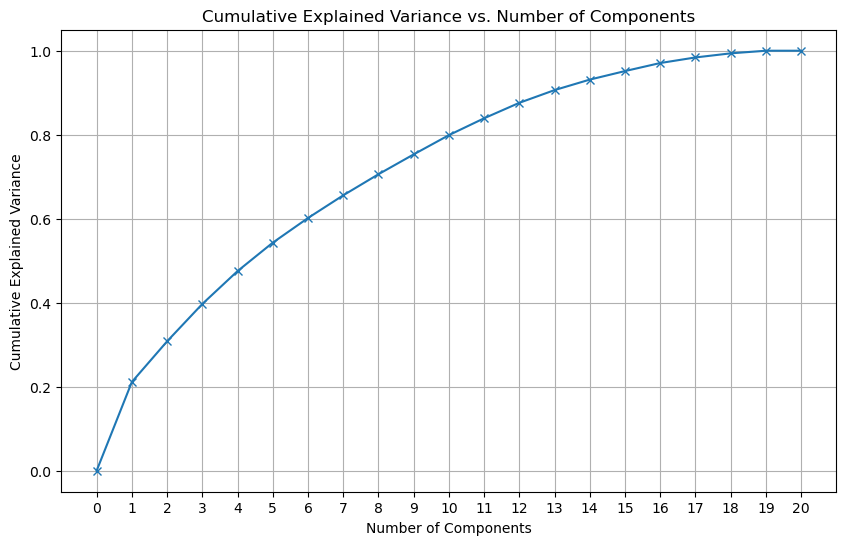

In [106]:
n_components_range = range(len(df_encoded.columns))

# standardize data before PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# PCA for each number of components
explained_variance = []
cumulative_variance = []
for n_components in n_components_range:
    pca = PCA(n_components = n_components)
    pca.fit(scaled_data)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    cumulative_variance.append(np.sum(pca.explained_variance_ratio_))
    
# plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cumulative_variance, marker='x')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xticks(n_components_range)
plt.grid()


Selecting the number of components is of course a trade-off between reducing dimensionality and retaining as much information as possible. Higher numbers of components might capture more variance but can also lead to overfitting. On the other hand, too few components may result in a significant loss of information.


In [107]:
for  index, i in enumerate(cumulative_variance):
    print(index,' : ',  i)

0  :  0.0
1  :  0.2113264356656637
2  :  0.3080505376322441
3  :  0.39704737978751053
4  :  0.4752834941167943
5  :  0.5429747459927657
6  :  0.6016665377143636
7  :  0.6556971721264888
8  :  0.7059124733045627
9  :  0.753153922396772
10  :  0.7990197721817767
11  :  0.8391663125323114
12  :  0.8759883820807352
13  :  0.9062714490764044
14  :  0.9312549994795771
15  :  0.9515570466225252
16  :  0.9707255192509382
17  :  0.9840050661663997
18  :  0.9937527364558941
19  :  1.0
20  :  1.0


upto 15 principal component, it is able to explain 95% of variance

In [114]:
# returns the principal components needed to achieve a certain explained variance

dim_re = PCA(n_components=15)
trf_data = dim_re.fit_transform(scaled_data)

df_pca = pd.DataFrame(trf_data)
df_pca

0         1         2         3         4         5         6   \
0     2.583642 -1.746557  1.372783  1.858434  1.688280 -0.173731 -0.559184   
1    -1.762855 -1.879984  0.383889  0.173920 -2.591686  0.023309 -0.059554   
2     1.679294  0.778241 -1.021615  1.068509 -0.439549 -0.009491 -0.141831   
3    -2.400636  0.327198 -1.944398  0.770982 -0.694915 -0.280057 -0.633956   
4    -0.356861  1.140790 -0.019829 -1.021810  0.349850 -1.506707  0.192649   
...        ...       ...       ...       ...       ...       ...       ...   
2230  1.257165  1.205734  0.194704  1.336245 -0.591264 -0.070888  0.001943   
2231 -0.407495  1.948437  2.566347 -1.338972 -0.621074 -1.649445 -0.983184   
2232  1.631326 -2.455230 -0.772862  1.133402  0.269517 -0.156415 -0.104731   
2233  2.031731  1.446565  0.139520 -1.565085 -1.022272  2.237921 -0.708124   
2234 -0.835827  1.461651  1.462149 -1.271870  0.436415 -1.676229 -0.831732   

            7         8         9         10        11        12        13  \
0     0.340163  0.544631 -0.248916 -1.900352 -0.217807  0.596116  0.973894   
1    -0.705846 -0.087709  0.577761 -0.249057  0.757092  0.662752  0.399239   
2    -0.274259 -0.011125  0.848846  0.626555 -0.781792 -1.173269  1.028332   
3    -1.112757 -0.394633 -0.176381  1.154282  0.528038 -0.508133  0.413924   
4     0.858634 -0.758085 -2.107379  1.523262  0.820520  0.117848  0.701274   
...        ...       ...       ...       ...       ...       ...       ...   
2230  0.129876 -0.144204  0.614659  0.028420 -0.248368 -0.991789  0.017150   
2231 -1.230966 -0.031546 -1.329599 -0.079492  3.134932  0.336592  1.778793   
2232  0.445473 -0.406751 -1.065723 -0.327416  0.834781 -0.879422 -0.760065   
2233 -0.543965  0.141538  1.096261  0.827346 -0.228182 -0.178413  0.184270   
2234 -0.499623  0.779614 -0.333879 -1.520023 -0.058683  0.813399 -0.332738   

            14  
0     1.429512  
1    -0.077692  
2    -0.588790  
3     0.195042  
4     0.221488  
...        ...  
2230  0.571160  
2231 -1.016598  
2232 -0.741112  
2233 -0.041553  
2234 -0.958007  

[2235 rows x 15 columns]

## 4 Model Building

During this section we want to build three different unsupervised clustering models, namely K-Means, and Hierarchical Clustering, and compare their results both graphically and using different evaluation metrics. The metrics to be considered are:

* Silhouette
* Davies-Bouldin Index

Both are commonly used in the context of clustering. 'Silhouette' quantifies how well-separated the clusters are and measures their separation of data points within clusters. The score ranges from -1 to 1. The other evaluation metric called 'Davies-Bouldin Index' measures the average similarity between each cluster and its most similar cluster, relative to the average dissimilarity between the clusters. The lower the value the better the clusters are defined.

For hyperparameter tuning we will use grid search. This technique searches through a predefined set of hyperparameter values and creates a grid of all possible value combinations. Then it evaluates each combination using one of the mentioned evaluation metrics above.

### 4.1 K-Means (10 marks)

As already mentioned, K-Means is an unsupervised algorithm for clustering data points into distinct groups. It is a so-called distance-based algorithm since it tries to minimize the sum of squared distances between data points and their assigned cluster centers (= centroids). This optimization process iteratively updates the cluster assignments and the centroids to find the best solution. Each step aims to minimize the within-cluster variance and maximize the separation between clusters. Upfront, you have to specify the number of desired clusters as a hyperparameter.


### Basic model

In [115]:
# get a fresh copy of the PCA dataset
df_pca_kmeans = df_pca.copy(True)

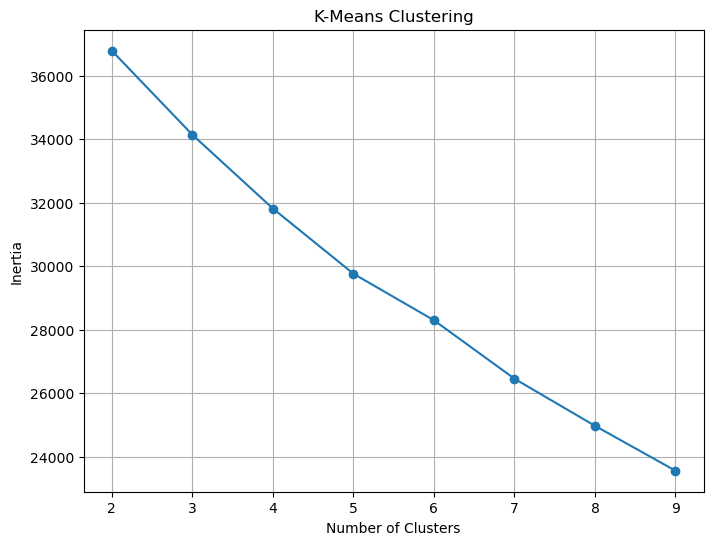

In [117]:
# try out different number of clusters
num_clusters_range = range(2,10)

# calculate the inertia (= within-cluster sum of squares) for each cluster
# this is a measure for how well the algorithm performs
# the lower the inertia the better the clusters are formed
inertia = []
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_pca_kmeans)
    inertia.append(kmeans.inertia_)

# plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-Means Clustering')
plt.grid()
plt.show()

The plot shows the inertia (= within cluster sum-of-squares) for each K (= number of clusters). We can see that the inertia becomes smaller for higher number of clusters. We could say that we should choose the highest possible value for K then. But of course clusters become less meaningful the more there are. Therefore, we have to choose a K big enough where we still get meaningful clusters. A popular technique to do so is called the Elbow Method where we try to find the K in the graph where the decline in inertia becomes significantly smaller. From the plot above we see that it is the case for K = 4.

Let's repeat the K-Means for this number of clusters and store the resulting cluster assignment in our dataset.

In [118]:
# Perform K-Means for optimal number of clusters according to Elbow Method
km = KMeans(n_clusters=4)
y_means = km.fit_predict(df_pca_kmeans)

In [120]:
y_means

array([3, 1, 3, ..., 3, 2, 2])

### Hyperparameter Optimization

Besides the inital value for K we can set an initial state that impacts how fast the algorithm converges. We will try to find the best pair of parameters using a hyperparameter optimization. As already mentioned, we try out two different evaluation metrics to compare with each other. One is called 'Silhouette' and the other is called 'Davies-Bouldin Index'.

In [119]:
# get a fresh copy of the PCA dataset
df_pca_kmeans = df_pca.copy(True)

In [122]:
def KMeansHyper(scoring, columnName):   
    
    # define the parameter grid
    param_grid = {
        'n_clusters': range(3,5), # number of clusters
        'n_init': [10, 20, 30, 40],  # number of times K-Means algorithm runs with different centroid seeds
        'init': ['k-means++', 'random'],  # different centroid initialization methods
    }

    # perform grid search
    kmeans = KMeans()
    grid_search = GridSearchCV(kmeans, param_grid, scoring=scoring)
    grid_search.fit(df_pca_kmeans)

    return grid_search

In [123]:
silhouette_scorer = make_scorer(silhouette_score)
grid_search_sil = KMeansHyper(silhouette_scorer, 'KMeans_Hyper_Sil')

In [124]:
davies_bouldin_scorer = make_scorer(davies_bouldin_score, greater_is_better=False)
grid_search_db = KMeansHyper(davies_bouldin_scorer, 'KMeans_Hyper_Bouldin')

In [133]:
print(grid_search_sil.best_params_)
print(grid_search_db.best_params_)

{'init': 'k-means++', 'n_clusters': 3, 'n_init': 10}
{'init': 'k-means++', 'n_clusters': 3, 'n_init': 10}


In [148]:
# fit best model and store cluster results
km = KMeans(n_clusters=3, init='k-means++', n_init=10 )
y_means_hyper = km.fit_predict(df_pca_kmeans)
y_means_hyper

array([1, 0, 1, ..., 1, 2, 2])

### 4.2 Hierarchical Clustering (10 marks)

Agglomerative Clustering is a bottom-up hierarchical clustering algorithm that initially begins with each data point as its own cluster. Then it iteratively merges the closest clusters based on a distance metric until a termination criterion is met. The time complexity is O(n^3), with n as the number of data points. The repeated computation of pairwise distances between clusters during each iteration is the reason for this complexity and makes it much more computationally expensive than K-Means and DBSCAN. However, for our case this should not be a problem because we are only working with roughly over 2000 data points.

Since this algorithm can handle different cluster shapes and sizes it seems appropriate for most datasets and also the one we are using. Our data might not be hierarchical by nature but this algorithm could help identify nested clusters.

### Basic model

Similar to K-Means we have to specify the value for the number of clusters upfornt. In order to evaluate resulting clusters we choose the silhouette_score as we did with the inertia for K-Means. The higher the silhouette_score, the better the clustering solution. In other words we are looking for a peak in the plot instead of using the Elbow Method.

In [136]:
# get a fresh copy of the PCA dataset
df_pca_agglo = df_pca.copy(True)

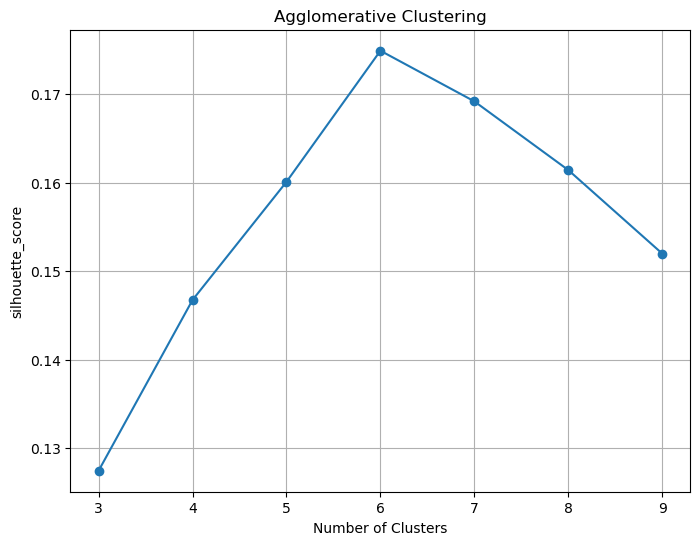

In [137]:
# try out different number of clusters
num_clusters_range = range(3,10)

# calculate the calinski_harabasz_score as a measure of how well the clusters are formed
silhouette = []
for num_clusters in num_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = agglo.fit_predict(df_pca_agglo)
    silhouette.append(silhouette_score(df_pca_agglo, cluster_labels))

# plot the index curve
plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette_score')
plt.title('Agglomerative Clustering')
plt.grid()
plt.show()

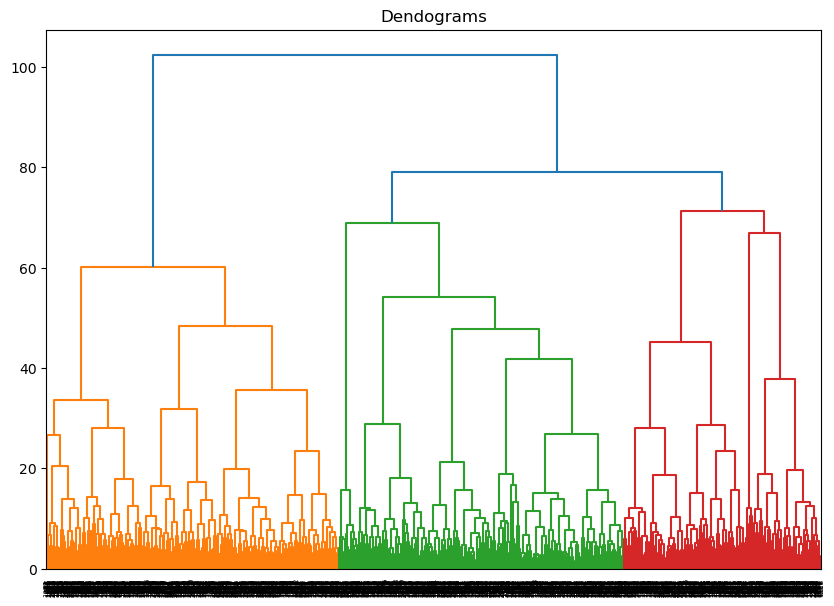

In [138]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10,7))
plt.title('Dendograms')
dend = shc.dendrogram(shc.linkage(df_pca_agglo, method='ward'))

In [140]:
# create a Agglomerative clustering model
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=3,linkage='ward')
cluster_labels = agc.fit_predict(df_pca_agglo)
cluster_labels

array([1, 2, 1, ..., 1, 0, 2], dtype=int64)

### Hyperparameter Optimization

Even though we have already found a good value for K, we let the hyperparameter search find the best value in combination with other parameters. Those are 'affinity' and 'linkage'. The first one refers to the distance metric used and the second one to the linkage criterion that decides whether two centroids are merged together or not.

In [141]:
# get a fresh copy of the PCA dataset
df_pca_agglo = df_pca.copy(True)

In [142]:
def AggloHyper(scoring, columnName):   
    
    # define the parameter grid
    param_grid = {
        'n_clusters': [3, 4, 5, 6],  # number of clusters
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan'],  # distance metric
        'linkage': ['ward', 'complete', 'average', 'single']  # linkage criterion
    }

    # perform grid search
    agglomerative = AgglomerativeClustering()
    grid_search = GridSearchCV(agglomerative, param_grid, scoring=scoring)
    grid_search.fit(df_pca_agglo)

    return grid_search

In [143]:
silhouette_scorer = make_scorer(silhouette_score)
grid_search_sil = AggloHyper(silhouette_scorer, 'Agglo_Hyper_Sil')

In [144]:
davies_bouldin_scorer = make_scorer(davies_bouldin_score, greater_is_better=False)
grid_search_db = AggloHyper(davies_bouldin_scorer, 'Agglo_Hyper_Bouldin')

In [145]:
# fit best model and store cluster results
print(grid_search_sil.best_params_)
print(grid_search_db.best_params_)

{'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 3}
{'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 3}


In [146]:
agc = AgglomerativeClustering(n_clusters=3,linkage='ward', affinity='euclidean')
cluster_labels = agc.fit_predict(df_pca_agglo)
cluster_labels

array([1, 2, 1, ..., 1, 0, 2], dtype=int64)